In [1]:
library('tidyverse')
library("hise")
library('data.table')
library('parallel')
library('dplyr')
library(patchwork)
library(ggplot2)
library(arrow)
set.seed(123)

Sys.setenv( TZ="Etc/GMT+1")
options(warn = -1)

Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

In [2]:
pesudo_time_df<-as.data.frame(read_parquet('02_TEAseq/CD4_T_cell_Traj/pesudo_time_df.parquet'))
pesudo_time_df<-pesudo_time_df[!is.na(pesudo_time_df$AIFI_L3),]
pesudo_time_df <- pesudo_time_df %>%
  mutate(cohort.x = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "BR2",
    TRUE ~ 'UP1' 
  ))

In [ ]:
pesudo_time_df<-pesudo_time_df %>% filter(celltype_new!='KLRF1- GZMB+ CD27- memory CD4 T cell')

pseudo_time_df_subset<-pesudo_time_df%>% filter(grepl("1",curve.assignments))

pseudo_time_df_subset <- pseudo_time_df_subset %>%
  mutate(mean_pseudo_time = rowMeans(select(., pesudo_time_1)))

In [9]:
patterns <- c("GATA3", "STAT6", "STAT5A",  "IRF4","TBX21")

matched_cols <- unlist(lapply(patterns, function(p) {
  colnames(pseudo_time_df_subset)[grepl(p, colnames(pseudo_time_df_subset))]
}))

matched_cols


[1] "motif_GATA3_384"  "motif_STAT6_776"  "motif_STAT5A_774" "motif_IRF4_632"  
[5] "motif_TBX21_780"

In [10]:
subset_data <- pseudo_time_df_subset %>%
  group_by(celltype_new) %>%
  group_modify(~ slice(.x, sample(nrow(.x), size = min(nrow(.x), 10000)))) %>%
  ungroup()

New names:
• `...1` -> `...63`
New names:
• `...1` -> `...63`
New names:
• `...1` -> `...63`
New names:
• `...1` -> `...63`
New names:
• `...1` -> `...63`
New names:
• `...1` -> `...63`


In [205]:
p_list <- list()
for (i in matched_cols) {
  
  p <- ggplot(subset_data, aes(pesudo_time_1, !!as.name(i), color = Age_Group)) +
    geom_smooth(method = "loess", aes(group = Age_Group, color = Age_Group), se = FALSE)
  
  smoothed_data <- ggplot_build(p)$data[[1]]
  
  smoothed_A <- smoothed_data[smoothed_data$colour == '#F8766D', c("x", "y")]
  smoothed_B <- smoothed_data[smoothed_data$colour == '#00BFC4', c("x", "y")]
  
  merged_data <- cbind(smoothed_A, smoothed_B)    
  colnames(merged_data) <- c("x.A", "y.A", "x.B", "y.B")
  merged_data$diff <- merged_data$y.B - merged_data$y.A  
  
  y_limit <- max(abs(range(merged_data$diff)))
  
  is_last <- i == tail(matched_cols, 1)
  
  p_list[[i]] <-ggplot(merged_data, aes(x = x.A, y = diff)) +
  geom_area(data = subset(merged_data, diff >= 0), fill = "#bf812d", alpha = 0.8) +
  geom_area(data = subset(merged_data, diff <= 0), fill = "#35978f", alpha = 0.8) +
  geom_line(color = "black", size = 0.1) +
  geom_hline(yintercept = 0, linewidth = 0.2, color = "black") +
  labs(
    y = NULL,
    x = if (is_last) "pesudo_time" else NULL
  ) +
  theme_classic(base_size = 6) +
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x  = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y       = element_blank(),
    axis.title.y.right = element_text(size = 6, angle = 0),
    axis.text.y.right  = element_blank(),
    axis.ticks.y.right = element_blank()
  ) +
  scale_y_continuous(
    limits  = c(-0.215, 0.215),
    sec.axis = sec_axis(~., name = str_extract(i, "(?<=_)[^_]+(?=_)"))
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 17)


}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


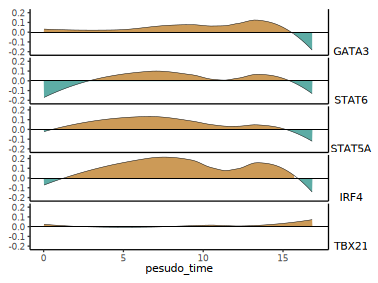

In [206]:
options(repr.plot.width = 80/25.4, repr.plot.height =60/25.4)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")

p_combined

In [207]:
summary_range<-subset_data %>% group_by(celltype_new) %>% summarize(
  max_range = quantile(pesudo_time_1, 0.95),
  min_range = quantile(pesudo_time_1, 0.05)
)

In [208]:
celltype_order<-summary_range %>% arrange(min_range) %>% select(celltype_new) %>% pull() 

In [209]:
subset_data$celltype_new<-factor(subset_data$celltype_new,levels=celltype_order)

Picking joint bandwidth of 0.25



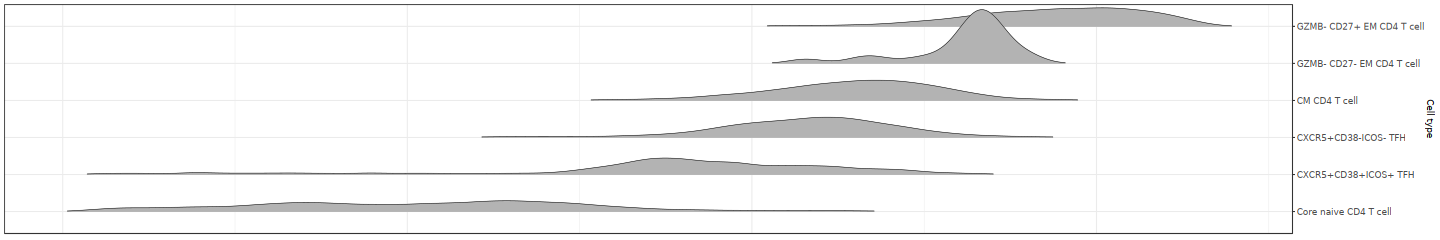

In [210]:
options(repr.plot.width = 12, repr.plot.height =2)
summary_range<-subset_data %>% group_by(celltype_new) %>% summarize(
  max_range = quantile(pesudo_time_1, 0.95),
  min_range = quantile(pesudo_time_1, 0.05)
)
library(ggridges)

p1 <- ggplot(subset_data, aes(x = pesudo_time_1, y = celltype_new)) +
  geom_density_ridges_gradient(scale = 1.45, rel_min_height = 0.01, linewidth = 0.1) +
  scale_fill_viridis_c(option = "D") +
  scale_y_discrete(
    name = "Cell type",
    position = "right",
    labels = function(x) str_wrap(x, width = 28)
  ) +
  theme_ridges(center_axis_labels = TRUE) +
  theme_bw(base_size = 5) +
  labs(x = "Pseudotime", fill = "Pseudotime") +
  theme(
    axis.text.y = element_text(size = 5),
    axis.title.x = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank()
  ) +
  xlim(0, 17)

p1

Picking joint bandwidth of 0.25

Picking joint bandwidth of 0.25



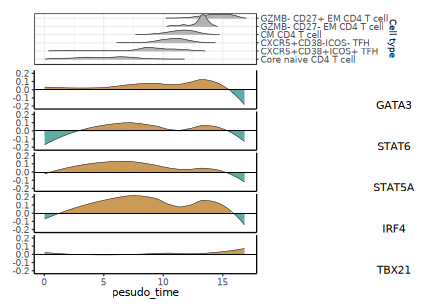

In [212]:
options(repr.plot.width = 90/25.4, repr.plot.height =65/25.4)

p_combined_final<-p1 / p_combined+ plot_layout(heights = c(0.25, 1))
p_combined_final
ggsave("FigureE.pdf", 
       p_combined_final, 
       width =  90/25.4, 
       height = 65/25.4)
